<a href="https://colab.research.google.com/github/Rakeshscode/Data-Science/blob/main/Unit6Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
import bambi as bmb

from scipy.interpolate import PchipInterpolator

In [ ]:
#load the data into a pandas dataframe, and print it
url_lf = 'https://raw.githubusercontent.com/Rakeshscode/Data-Science/refs/heads/main/Life%20Expectancy%20Data.csv'
#I could have put the url string directly into pd.read_csv()
data1 = pd.read_csv(url_lf)
data1 = data1.dropna()
data1 = data1[['Total expenditure','Life expectancy ','under-five deaths ','infant deaths','Adult Mortality','Alcohol']]
data1

,Total expenditure,Life expectancy,under-five deaths,infant deaths,Adult Mortality,Alcohol
0,8.16,65.0,83,62,263.0,0.01
1,8.18,59.9,86,64,271.0,0.01
2,8.13,59.9,89,66,268.0,0.01
3,8.52,59.5,93,69,272.0,0.01
4,7.87,59.2,97,71,275.0,0.01
...,...,...,...,...,...,...
2933,7.13,44.3,42,27,723.0,4.36
2934,6.52,44.5,41,26,715.0,4.06
2935,6.53,44.8,40,25,73.0,4.43
2936,6.16,45.3,39,25,686.0,1.72


In [ ]:
print(data1.columns)

Index(['Total expenditure', 'Life expectancy ', 'under-five deaths ',
       'infant deaths', 'Adult Mortality', 'Alcohol'],
      dtype='object')


**Variable Selection and Model Justification**

To determine the best set of variables, I tested multiple model specifications:

Full model with interactions (lf_u5_id_te_am_al): This includes all predictors and their interactions.

Model without interactions (lf_u5_id_te_am_al2): This contains all main effects but excludes interaction terms.

Reduced model focusing on expenditure and child mortality (lf_u5_id_te): This simplifies the model by excluding adult mortality and alcohol variables.

Reduced model focusing on adult mortality and alcohol (lf_am_al): This tests whether life expectancy can be adequately predicted with just these two variables.

In [ ]:
lf_u5_id_te_am_al = bmb.Model("`Life expectancy ` ~ `Total expenditure` + 'under-five deaths ' + `infant deaths` + 'Adult Mortality' + 'Alcohol' + `Total expenditure`*'under-five deaths ' +  `Total expenditure`*`infant deaths` + 'Alcohol'*'Adult Mortality'", data=data1).fit(idata_kwargs={"log_likelihood":True})


Output()

Output()

In [ ]:
lf_u5_id_te = bmb.Model("`Life expectancy ` ~ `Total expenditure` + 'under-five deaths ' + `infant deaths` + `Total expenditure`*'under-five deaths ' +  `Total expenditure`*`infant deaths` ", data=data1).fit(idata_kwargs={"log_likelihood":True})


Output()

Output()

In [ ]:
lf_am_al = bmb.Model("`Life expectancy ` ~  'Adult Mortality' + 'Alcohol' + 'Alcohol'*'Adult Mortality'", data=data1).fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [ ]:
lf_u5_id_te_am_al2 = bmb.Model("`Life expectancy ` ~ `Total expenditure` + 'under-five deaths ' + `infant deaths` + 'Adult Mortality' + 'Alcohol'", data=data1).fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

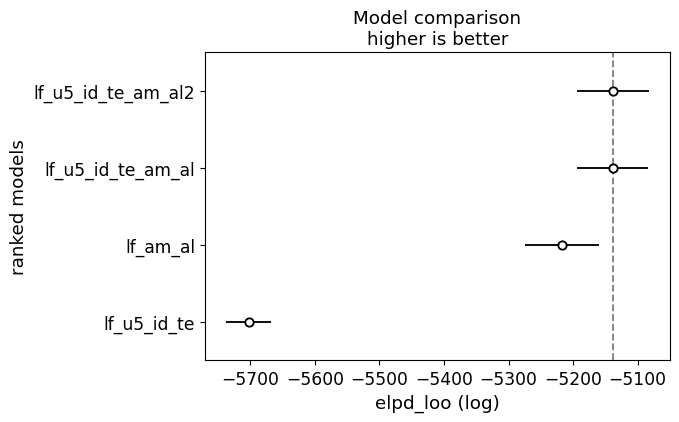

In [ ]:
compare = az.compare({"lf_u5_id_te_am_al":lf_u5_id_te_am_al, "lf_u5_id_te":lf_u5_id_te, "lf_am_al":lf_am_al, "lf_u5_id_te_am_al2":lf_u5_id_te_am_al2})
az.plot_compare(compare)

**Model Comparison Findings**

The model without interactions (lf_u5_id_te_am_al2) was the highest-ranked model in terms of elpd_loo.

However, the full model with interactions (lf_u5_id_te_am_al) is still useful because it accounts for the real-world complexity of relationships between variables.

lf_am_al, which only includes adult mortality and alcohol, performed well indicating that these two variables alone do not sufficiently explain life expectancy variation.

The lf_u5_id_te model, which only includes expenditure and child mortality, performed the worst probably because it lacks critical health-related predictors like alcohol consumption and adult mortality.

**Rationale for Including Interactions Despite Model Comparison Results**

In real-world settings, variables do not operate in isolation; they interact with each other and influence outcomes in complex ways. Although the model comparison suggests that the model without interactions has the best fit, I am still choosing to use the model that includes interactions. This decision is based on domain knowledge and theoretical justification rather than purely on model comparison metrics.

For instance:

Total expenditure and under-five deaths: Higher total expenditure should generally reduce under-five deaths, but the extent of this effect may depend on other factors like healthcare infrastructure and public health policies.

Total expenditure and infant deaths: Similar to under-five deaths, the reduction in infant mortality due to increased expenditure might not be linear and could be influenced by additional variables such as vaccination programs and maternal care.

Alcohol and Adult Mortality: While alcohol consumption is generally linked to increased mortality, the relationship may vary depending on consumption patterns, societal factors, and healthcare access.

By including these interaction terms, I am capturing the way these variables influence life expectancy together rather than assuming they act independently.

In [ ]:
model1 = bmb.Model("`Life expectancy ` ~ `Total expenditure` + 'under-five deaths ' + `infant deaths` + 'Adult Mortality' + 'Alcohol' + `Total expenditure`*'under-five deaths ' +  `Total expenditure`*`infant deaths` + 'Alcohol'*'Adult Mortality'", data=data1)
idata_model1 = model1.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


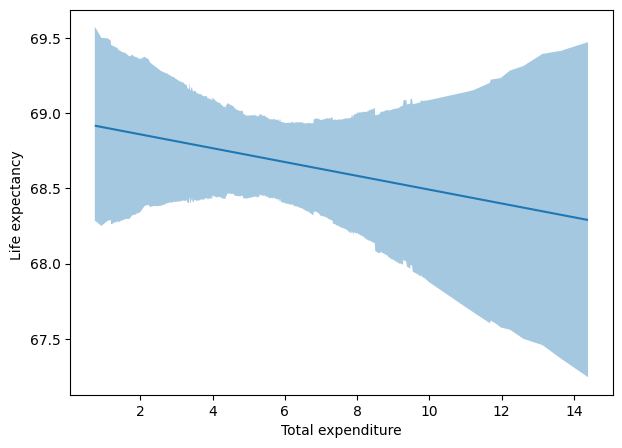

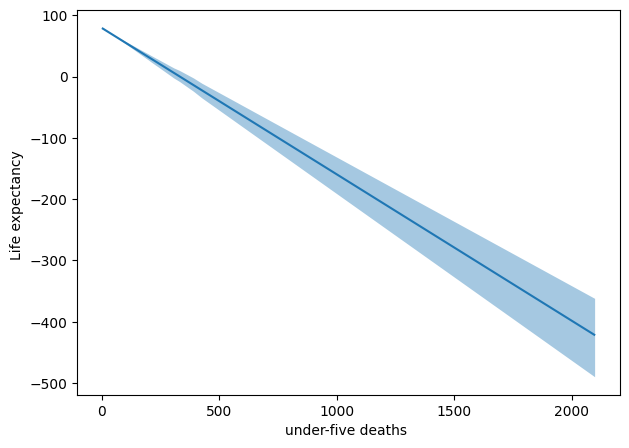

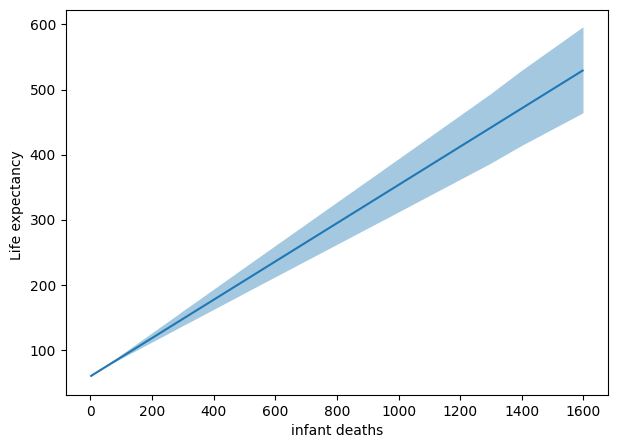

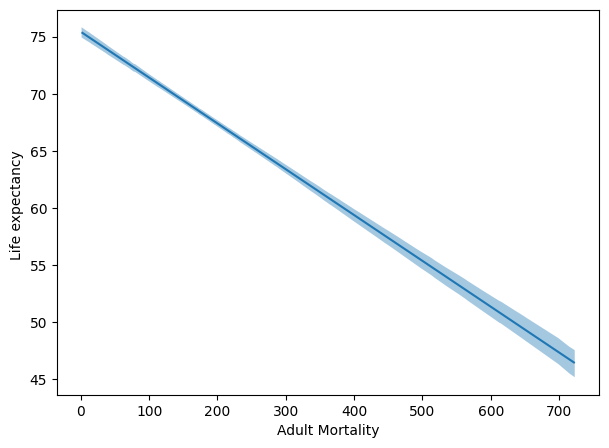

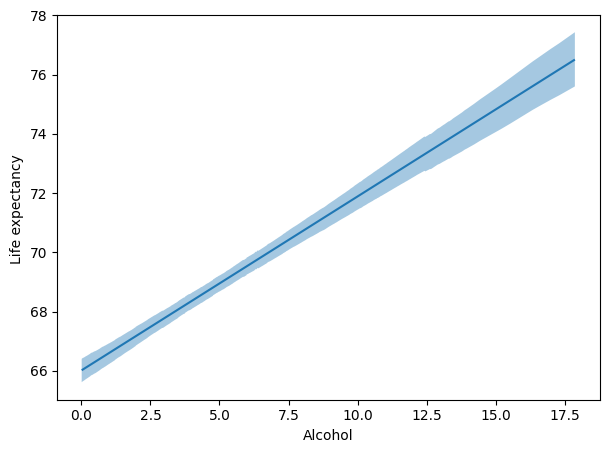

In [ ]:
variables = ["Total expenditure", "under-five deaths ", "infant deaths", "Adult Mortality", "Alcohol"]

for var in variables:
    bmb.interpret.plot_predictions(
        model1,
        idata_model1,
        conditional={var: data1[var]}, # Pass a dictionary with column name and its values
        average_by=[var],
        fig_kwargs={"figsize": (7, 5)}
    )
